# AC209 Project: Predicting the returns on Cryptocurrencies

by Ali Dastjerdi, Angelina Massa, Sachin Mathur & Nate Stein

### Project Goal

To predict the price return of one cryptocurrency based on the returns of other cryptocurrencies; market data, including equity indices and other benchmarks; and cryptocurrency news.

### Work Load

1. Creating basic data pipelines and evaluating different model possibilities.
2. Using NLP techniques to convert unstructured news data concerning cryptocurrencies into features that can be fed into model.

### Cryptocurrency Scope

We focus on cryptocurrencies that have data going back to 2015 or earlier so we have more data points: btc, ltc, xrp, xlm, eth.

**SOUND FAIR?**

#### Earliest date data available
For top 10 cryptocurrencies in terms of market-cap, the following dates are the earliest dates closing price data is available:

    btc	4/28/2013
    ltc	4/28/2013
    xrp	8/4/2013
    xlm	8/5/2014
    eth	8/7/2015
    neo	9/9/2016
    miota	6/13/2017
    eos	7/1/2017
    bch	7/23/2017
    ada	10/1/2017

In [1]:
import crypto_utils as crypu
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

from crypto_utils import fmt_date, print_update
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

In [2]:
# Custom output options.

np.set_printoptions(precision=3, suppress=True)
pd.set_option('display.precision', 3)
sns.set_style('white')
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.05
%matplotlib inline

# EDA

### Basic Data Features

Here we create two time series containing the daily rolling returns for a subset of cryptocurrencies: (i) raw daily returns and (ii) daily returns centered and scaled to unit variance with respect to each cryptocurrency.

For example, the value for `btc` on 2015-08-09 in the raw DataFrame will be equal to:

$$\frac{\text{btc}_t}{\text{btc}_{t-1}}-1 = \frac{265.08}{261.00}-1=1.56\%$$

where $\text{btc}_t$ is the closing price of `btc` on 2015-08-09 and $\text{btc}_{t-1}$ is the closing price of `btc` on the previous day, 2015-08-08.

In [6]:
# Load rolling returns time series.

CRYPTO_SCOPE = ['btc', 'ltc', 'xrp', 'xlm', 'eth']
tdelta = pd.Timedelta(days=1)
analysis_end_dt = pd.to_datetime('3/31/2018')
crypto_df_raw = crypu.load_returns_matrix (CRYPTO_SCOPE, 
                                           end_date=analysis_end_dt, 
                                           tdelta=tdelta, center=False, 
                                           scale=False)
crypto_df_std = crypu.load_returns_matrix (CRYPTO_SCOPE, 
                                           end_date=analysis_end_dt, 
                                           tdelta=tdelta, center=True, 
                                           scale=True)

In [7]:
# No reason start dates should be different for raw and standardized 
# DataFrames.
analysis_start_dt = pd.to_datetime(crypto_df_raw.index.values.min())
assert analysis_start_dt == crypto_df_std.index.values.min()
assert analysis_end_dt == crypto_df_std.index.values.max()

analysis_daycount = (analysis_end_dt - analysis_start_dt).days

print('Rolling returns time period:')
print('\tStart date: {}'.format(fmt_date(analysis_start_dt)))
print('\tEnd date: {}'.format(fmt_date(crypto_df_raw.index.values.max())))
print('\tObservations: {}'.format(crypto_df_raw.shape[0]))
print('\nRaw DataFrame:')
display(crypto_df_raw.head())
print('Standardized DataFrame:')
display(crypto_df_std.head())

Rolling returns time period:
	Start date: 08/08/2015
	End date: 03/31/2018
	Observations: 967

Raw DataFrame:


,btc,ltc,xrp,xlm,eth
date,,,,,
2015-08-08,-0.066,-0.086,0.040,-0.005,-0.728
2015-08-09,0.016,0.013,0.039,-0.031,-0.068
2015-08-10,-0.002,0.013,-0.007,0.052,0.009
2015-08-11,0.022,0.053,-0.018,-0.028,0.510
2015-08-12,-0.015,-0.041,-0.037,-0.008,0.140


Standardized DataFrame:


,btc,ltc,xrp,xlm,eth
date,,,,,
2015-08-08,-1.707,-1.426,0.326,-0.140,-9.351
2015-08-09,0.277,0.121,0.320,-0.386,-0.974
2015-08-10,-0.157,0.118,-0.148,0.416,0.011
2015-08-11,0.440,0.752,-0.266,-0.357,6.373
2015-08-12,-0.460,-0.725,-0.461,-0.161,1.673


### Analysis of Unstandardized Daily Price Return Data

First we take a look at what the raw daily price return data looks like, i.e., the rolling daily returns that are not centered/scaled by cryptocurrency.

In [8]:
print('Price return statistics without centering/scaling:')
print('Mean returns:')
display(crypto_df_raw.mean(axis=0))
print('Standard deviation of returns:')
display(crypto_df_raw.std(axis=0))
print('Cumulative return:')
display((crypto_df_raw + 1).prod(axis=0))
print('Correlation:')
crypto_df_raw.corr()

Price return statistics without centering/scaling:
Mean returns:


btc    0.004
ltc    0.005
xrp    0.008
xlm    0.009
eth    0.008
dtype: float64

Standard deviation of returns:


btc    0.041
ltc    0.064
xrp    0.098
xlm    0.103
eth    0.079
dtype: float64

Cumulative return:


btc     24.943
ltc     27.698
xrp     62.850
xlm     85.024
eth    143.126
dtype: float64

Correlation:


,btc,ltc,xrp,xlm,eth
btc,1.000,0.512,0.187,0.259,0.299
ltc,0.512,1.000,0.255,0.281,0.273
xrp,0.187,0.255,1.000,0.473,0.119
xlm,0.259,0.281,0.473,1.000,0.167
eth,0.299,0.273,0.119,0.167,1.000


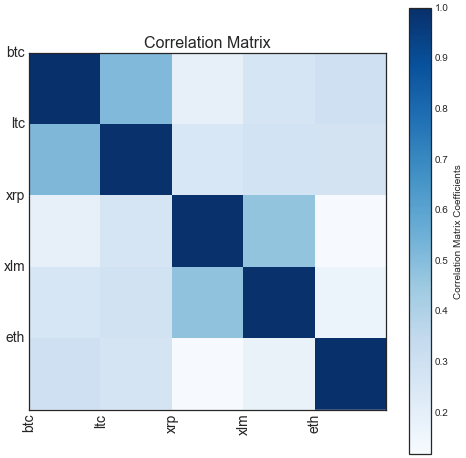

In [6]:
# Correlation matrix graph.

corr = np.corrcoef(crypto_df_raw.values.T)
plt.figure(figsize=(8, 8))
plt.imshow(corr, cmap='Blues', interpolation='none')
cb = plt.colorbar()
cb.set_label('Correlation Matrix Coefficients')
plt.title('Correlation Matrix', fontsize=16)

# Shift axes ticks b/c they defualt to center of squares.
ticks = np.arange(-0.5, len(CRYPTO_SCOPE), 1)
tick_labels = np.arange(1, len(CRYPTO_SCOPE), 1)
plt.xticks(ticks, CRYPTO_SCOPE, rotation=90, size=14)
plt.yticks(ticks, CRYPTO_SCOPE, size=14)
plt.savefig('plots/corr.png', bbox_inches='tight')

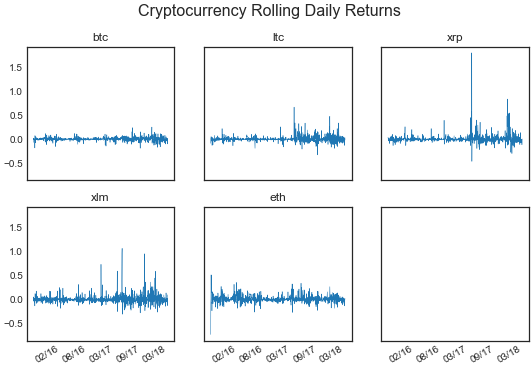

In [14]:
# Graph returns.

LW = 0.5  # line width
TS = 12  # subplot title size

# Number of rows and columns we'll need for all subplots.
INCHES_PER_ROW, INCHES_PER_COL = 3, 3
ax_rows, ax_cols = 2, 3
figsize = (ax_cols*INCHES_PER_COL, ax_rows*INCHES_PER_ROW)

# Create xticks so we have only 5 ticks.
desired_ticks = 5
days_per_tick = int(analysis_daycount/desired_ticks)
xticks = [analysis_start_dt + datetime.timedelta(days=x_*days_per_tick) for 
          x_ in range(1, desired_ticks+1)]

f, ax = plt.subplots(ax_rows, ax_cols, figsize=figsize,
                     sharex=True, sharey=True)
xaxis_fmt = mdates.DateFormatter('%m/%y')
row = 0
col = 0

for crypto in CRYPTO_SCOPE:
    ax[row, col].plot(crypto_df_raw[crypto], linewidth=LW)
    ax[row, col].set_title(crypto, size=TS)
    ax[row, col].set_xticks(xticks)
    ax[row, col].xaxis.set_major_formatter(xaxis_fmt)
    
    # Increment axis index.
    if ((col + 1)%ax_cols)==0:
        # Move to next row since we're at last column.
        col = 0
        row += 1
    else:
        col += 1

f.autofmt_xdate()  #  so dates are rotated nicely on x-axis
f.suptitle('Cryptocurrency Rolling Daily Returns', size=16)
plt.savefig('plots/daily_rolling_all.png', bbox_inches='tight')

#### Histogram of Cryptocurrency Returns

*For unstandardized cryptocurrency returns*

Bin boundaries:
-0.88%
0.31%
1.92%


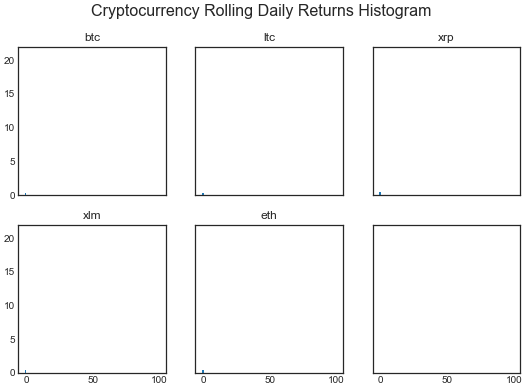

In [15]:
# Dimensions will be same as rolling return subplots.
f_hist, ax_hist = plt.subplots(ax_rows, ax_cols, figsize=figsize,
                               sharex=True, sharey=True)
row, col = 0, 0
bins = 5

# Base bin boundaries for all histograms on bitcoin's quantiles.
btc_bins = [-1.0]
for qtile in [0.25, 0.5, 0.75]:
    btc_bins.append(crypto_df_raw['btc'].quantile(qtile))
btc_bins.append(100.0)

print('Bin boundaries:')
for b in btc_bins[1:-1]:
    print('{:.2%}'.format(b))

for crypto in CRYPTO_SCOPE:
    ax_hist[row, col].hist(crypto_df_raw[crypto], bins=btc_bins, normed=True)
    ax_hist[row, col].set_title(crypto, size=TS)
    
    # Increment axis index.
    if ((col + 1)%ax_cols)==0:
        # Move to next row since we're at last column.
        col = 0
        row += 1
    else:
        col += 1

f_hist.suptitle('Cryptocurrency Rolling Daily Returns Histogram', size=16)
f_hist.savefig('plots/histogram_all.png')

In [16]:
btc_bins

[-1.0,
 -0.008767714173464114,
 0.0031243558728126786,
 0.019168660516522884,
 100.0]

# Prepare model data

#### Definition of rolling returns

We aim to One cryptocurrency's return will be the $Y$ value while the other currencies' returns will be the $X$.

In below example, `btc` is the cryptocurrency whose price return we try to predict. Therefore, one example of row in our training data would contain:
- Index: 3/30/2018
- $Y$: `btc`'s percentage change in `close` price from 3/29/2018 -> 3/30/2018.
- $X$: The other cryptocurrencies' percentage change in `close` price from 3/28/2018 -> 3/29/2018.

i.e., we want to use the rolling returns from the other cryptocurrencies on 3/29/2018 to predict the return of `btc` on the next day (3/30/2018).

For example, the price return for `eth` on original frame at 10/3/2017 was equal to $-0.329$. After shifting the returns forward one day in the following code, the price return for `eth` on 10/3/2017 becomes $-0.316$, the value for 10/2/2017 in the previous DF. 

In [17]:
y_currency = 'btc'  # crypto whose return we want to predict
x_currencies = [c for c in crypto_df_std.columns if c != y_currency]
crypto_df_model = crypto_df_std.copy()
crypto_df_model[x_currencies] = crypto_df_model[x_currencies].shift(
    periods=1, freq=tdelta)
crypto_df_model.dropna(axis=0, how='any', inplace=True)
crypto_df_model.head()

,btc,ltc,xrp,xlm,eth
date,,,,,
2015-08-09,0.277,-1.426,0.326,-0.140,-9.351
2015-08-10,-0.157,0.121,0.320,-0.386,-0.974
2015-08-11,0.440,0.118,-0.148,0.416,0.011
2015-08-12,-0.460,0.752,-0.266,-0.357,6.373
2015-08-13,-0.310,-0.725,-0.461,-0.161,1.673


## Replacing cryptocurrency returns with PCA components

In [65]:
# Placeholder

## Extracting news features using NLP

In [21]:
from nytimesarticle import articleAPI
api = articleAPI('f321bc4762f94995a9075b9c54733a44')

In [29]:
import requests
"""
About:
Python wrapper for the New York Times Archive API 
https://developer.nytimes.com/article_search_v2.json
"""

class APIKeyException(Exception):
    def __init__(self, message): self.message = message 

class InvalidQueryException(Exception):
    def __init__(self, message): self.message = message 

class ArchiveAPI(object):
    def __init__(self, key=None):
        """
        Initializes the ArchiveAPI class. Raises an exception if no API key is given.
        :param key: New York Times API Key
        """
        self.key = key
        self.root = 'http://api.nytimes.com/svc/archive/v1/{}/{}.json?api-key={}' 
        if not self.key:
            nyt_dev_page = 'http://developer.nytimes.com/docs/reference/keys'
            exception_str = 'Warning: API Key required. Please visit {}'
            raise NoAPIKeyException(exception_str.format(nyt_dev_page))

    def query(self, year=None, month=None, key=None,):
        """
        Calls the archive API and returns the results as a dictionary.
        :param key: Defaults to the API key used to initialize the ArchiveAPI class.
        """
        if not key: key = self.key
        if (year < 1882) or not (0 < month < 13):
            # currently the Archive API only supports year >= 1882
            exception_str = 'Invalid query: See http://developer.nytimes.com/archive_api.json'
            raise InvalidQueryException(exception_str)
        url = self.root.format(year, month, key)
        r = requests.get(url)
        return r.json()

In [56]:
api = ArchiveAPI('93af2608c5b24286a5b53fc67232b554')
articles = []
exclusions = [(2015, 1), (2015, 2), (2015, 3), (2015, 4), (2015, 5), (2015, 6), (2015, 7), (2018, 4), (2018, 5), (2018, 6), (2018, 7), (2018, 8), (2018, 9), (2018, 10), (2018, 11), (2018, 12)]
for year in [2015,2016,2017,2018]:
    for month in range(1,13):
        if (year,month) not in exclusions:
            print((year, month))
            articles += api.query(year, month)['response']['docs']
        


(2015, 8)
(2015, 9)
(2015, 10)
(2015, 11)
(2015, 12)
(2016, 1)
(2016, 2)
(2016, 3)
(2016, 4)
(2016, 5)
(2016, 6)
(2016, 7)
(2016, 8)
(2016, 9)
(2016, 10)
(2016, 11)
(2016, 12)
(2017, 1)
(2017, 2)
(2017, 3)
(2017, 4)
(2017, 5)
(2017, 6)


KeyError: 'response'

In [61]:
exclusions = [(2017, 1), (2017, 2), (2017, 3), (2017, 4), (2017, 5), (2018, 4), (2018, 5), (2018, 6), (2018, 7), (2018, 8), (2018, 9), (2018, 10), (2018, 11), (2018, 12)]
for year in [2017,2018]:
    for month in range(1,13):
        if (year,month) not in exclusions:
            print((year, month))
            articles += api.query(year, month)['response']['docs']

(2017, 6)
(2017, 7)
(2017, 8)
(2017, 9)
(2017, 10)
(2017, 11)
(2017, 12)
(2018, 1)


KeyError: 'response'

In [62]:
for year in [2018]:
    for month in range(2,13):
        if (year,month) not in exclusions:
            print((year, month))
            articles += api.query(year, month)['response']['docs']

(2018, 2)
(2018, 3)


In [65]:
import json
with open('articles.txt', 'w') as outfile:
    json.dump(articles, outfile)

In [73]:
'news_desk' in articles[0].keys()

True

In [126]:
desks = []
desired_desks = ['Business','Foreign','National']
filtered = []
for article in sections_filtered:
    if 'type_of_material' in article.keys():
        desks += [article['type_of_material']]

values, counts = np.unique(desks, return_counts= True)
sorted((list(zip(counts, values))), reverse= True)

[(34791, 'News'),
 (1395, 'Brief'),
 (1324, 'Blog'),
 (639, 'Question'),
 (501, 'Obituary (Obit)'),
 (271, 'Obituary'),
 (269, 'briefing'),
 (165, 'List'),
 (142, 'News Analysis'),
 (120, 'An Analysis; News Analysis'),
 (95, 'Biography'),
 (46, 'Text'),
 (35, 'Interview'),
 (27, 'Special Report'),
 (26, 'Newsletter'),
 (23, 'Schedule'),
 (6, 'Review'),
 (6, 'Editorial'),
 (5, 'Letter'),
 (4, 'Series')]

In [103]:
desks = []
desired_desks = ['Business','Foreign','National']
filtered = []
for article in articles:
    if 'news_desk' in article.keys():
        if article['news_desk'] in desired_desks: 
            filtered += [article]

In [121]:
sections_filtered = []
desired_sections = ['U.S.','World', 'Business Day', 'Technology','Real Estate', 'Politics', 'Economy', 'Europe', 'Asia Pacific', 'Middle East', 'Americas', 'Africa', 'Job Market', 'Australia', 'Canada']
for article in filtered:
    if 'section_name' in article.keys():
        if article['section_name'] in desired_sections: 
            sections_filtered += [article]

In [127]:
news_filtered = []
desired_type = ['News']
for article in sections_filtered:
    if 'type_of_material' in article.keys():
        if article['type_of_material'] in desired_type: 
            news_filtered += [article]

In [131]:
news_filtered[0].keys()

dict_keys(['web_url', 'snippet', 'lead_paragraph', 'abstract', 'print_page', 'blog', 'source', 'multimedia', 'headline', 'keywords', 'pub_date', 'document_type', 'news_desk', 'section_name', 'subsection_name', 'byline', 'type_of_material', '_id', 'word_count', 'slideshow_credits'])

In [132]:
print(news_filtered[0]['abstract'])
print(news_filtered[0]['headline']['main'])
print(news_filtered[0]['keywords'])
print(news_filtered[0]['pub_date'])

Rite Aid and Food Lion will put issues of Cosmopolitan magazine behind holders that will prevent minors from seeing magazine's sexual content.
Cosmopolitan Magazine Covers to Be Shielded by 2 Retailers
[{'rank': '1', 'is_major': 'Y', 'name': 'organizations', 'value': 'Cosmopolitan (Magazine)'}, {'rank': '2', 'is_major': 'Y', 'name': 'organizations', 'value': 'Food Lion Inc'}, {'rank': '3', 'is_major': 'Y', 'name': 'organizations', 'value': 'Rite Aid Corporation'}, {'rank': '4', 'is_major': 'N', 'name': 'subject', 'value': 'Shopping and Retail'}, {'rank': '5', 'is_major': 'N', 'name': 'subject', 'value': 'Magazines'}]
2015-08-01T00:00:00Z


In [145]:
news_filtered[0]['keywords'][1]['is_major']

'Y'

In [183]:
data = []
for article in news_filtered:
    entry = {}
    entry['headline'] = article['headline']['main']
    entry['date'] = article['pub_date']
    entry['keywords'] = make_key_string(get_keys(article))
    data += [entry]

In [184]:
data = pd.DataFrame(data)

In [199]:
data['date'] = pd.to_datetime(data['date'].apply(lambda x: x[:10]))

True

In [207]:
cyrpto_phrase = ['cryptocurrency', 'Bitcoin', 'Litecoin', 'Ripple','Stellar', 'Ethereum',  'Neo', 'IOTA', 'EOS', 'Bitcoin Cash', 'Ada']

In [209]:
data['crypto_phrase'] = data['keywords'].apply(lambda x: 1 if any(word in x for word in cyrpto_phrase) else 0)

In [212]:
data.sort_values('crypto_phrase', ascending=False)

,date,headline,keywords,crypto_phrase
32226,2017-06-02,Devin Nunes Is Criticized for Keeping Subpoena...,"Nunes, Devin G United States Politics and Gove...",1
34497,2017-07-26,A Test for the Market in Initial Coin Offerings,Currency Securities and Exchange Commission De...,1
28905,2017-05-15,What Is Bitcoin? All About the Mysterious Digi...,Bitcoin (Currency) Virtual Currency Computers ...,1
27109,2017-04-06,Christian Bale in Talks to Play Dick Cheney in...,Academy Awards (Oscars) Paramount Pictures Ada...,1
2383,2015-09-25,Israel Acts to Combat Violence in Jerusalem,Israel Palestinians Jerusalem (Israel) Rock an...,1
22961,2016-12-03,Gambians Celebrate Defeat of Longtime President,"Gambia Jammeh, Yahya Barrow, Adama (1965- ) Af...",1
33044,2017-06-19,Justices to Hear Major Challenge to Partisan G...,United States Politics and Government Redistri...,1
4566,2015-11-05,New Passport in Britain Puts Women in 2nd Class,Great Britain Passports Women and Girls Lovela...,1
24841,2017-01-19,Troops Enter Gambia as New President Is Sworn In,"Gambia Barrow, Adama (1965- ) Jammeh, Yahya El...",1
23758,2016-12-21,YouTube Stars Say They Were Removed From Delta...,Delta Air Lines Inc Discrimination Muslim Amer...,1


In [219]:
data.to_csv('data.csv')

In [221]:
def implicit():
    from google.cloud import storage

    # If you don't specify credentials when constructing the client, the
    # client library will look for credentials in the environment.
    storage_client = storage.Client()

    # Make an authenticated API request
    buckets = list(storage_client.list_buckets())
    print(buckets)

In [225]:
!pip install google.cloud

    100% |████████████████████████████████| 51kB 1.7MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 2.8MB/s ta 0:00:011
    100% |████████████████████████████████| 143kB 2.9MB/s ta 0:00:01
    100% |████████████████████████████████| 92kB 3.5MB/s ta 0:00:011
    100% |████████████████████████████████| 92kB 2.9MB/s ta 0:00:011
    100% |████████████████████████████████| 61kB 4.0MB/s ta 0:00:011
    100% |████████████████████████████████| 81kB 4.5MB/s ta 0:00:011
    100% |████████████████████████████████| 51kB 2.4MB/s ta 0:00:011
    100% |████████████████████████████████| 51kB 383kB/s ta 0:00:011
    100% |████████████████████████████████| 153kB 536kB/s ta 0:00:01
    100% |████████████████████████████████| 71kB 2.9MB/s ta 0:00:011
    100% |████████████████████████████████| 71kB 4.2MB/s ta 0:00:011
    100% |████████████████████████████████| 51kB 6.6MB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 4.8MB/s ta 0:00:011
    100% |█████████████████████████

  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 51kB 6.5MB/s eta 0:00:01
  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 61kB 5.6MB/s eta 0:00:01
  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 71kB 5.5MB/s ta 0:00:011
    100% |████████████████████████████████| 163kB 3.7MB/s ta 0:00:01
    100% |████████████████████████████████| 829kB 1.4MB/s ta 0:00:011
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 81kB 5.1MB/s ta 0:00:01
  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 71kB 5.5MB/s eta 0:00:01
  Cache entry deserialization failed, entry ignor

  Running setup.py bdist_wheel for googleapis-common-protos ... done
  Stored in directory: /Users/alidastjerdi/Library/Caches/pip/wheels/62/45/af/649bbf07b6595fda010be1bda667cd56d0444d07afc6f8b687
  Running setup.py bdist_wheel for gapic-google-cloud-logging-v2 ... done
  Stored in directory: /Users/alidastjerdi/Library/Caches/pip/wheels/67/f7/2c/c104c937201a0a2bba168ae7058ce7d10da96d881b504a1ae4
  Running setup.py bdist_wheel for gapic-google-cloud-datastore-v1 ... done
  Stored in directory: /Users/alidastjerdi/Library/Caches/pip/wheels/79/a9/0f/1b6929a5f1961d22553efa844ea60c589bffcf6e1bd019f7c9
  Running setup.py bdist_wheel for gapic-google-cloud-error-reporting-v1beta1 ... done
  Stored in directory: /Users/alidastjerdi/Library/Caches/pip/wheels/19/d9/9e/5d0f178712d65c20ef2e2573b4390f94864819fe0b29d91c8f
  Running setup.py bdist_wheel for dill ... done
  Stored in directory: /Users/alidastjerdi/Library/Caches/pip/wheels/99/c4/ed/1b64d2d5809e60d5a3685530432f6159d6a9959739facb61f2


In [226]:
implicit()

DefaultCredentialsError: Could not automatically determine credentials. Please set GOOGLE_APPLICATION_CREDENTIALS or
explicitly create credential and re-run the application. For more
information, please see
https://developers.google.com/accounts/docs/application-default-credentials.

In [170]:
def get_keys(article):
    keywords = []
    for keyword in article['keywords']:
        keywords += [keyword['value']]
    return keywords
        
        

In [7]:
def analyze_sentiment(text, encoding='UTF32'):
    body = {
        'document': {
            'type': 'PLAIN_TEXT',
            'content': text,
        },
        'encoding_type': encoding
    }

    service = googleapiclient.discovery.build('language', 'v1')

    request = service.documents().analyzeSentiment(body=body)
    response = request.execute()

    return response

In [11]:
import googleapiclient.discovery


In [9]:
!pip install google-auth-httplib2

  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
analyze_sentiment('Your mom is too fat')

ValueError: Credentials from google.auth specified, but google-api-python-client is unable to use these credentials unless google-auth-httplib2 is installed. Please install google-auth-httplib2.

In [171]:
counter = 0
for article in news_filtered: 
    keywords_string = []
    if 'Bitcoin' in make_key_string(get_keys(article)):
        counter += 1
        print(counter)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


In [163]:
make_key_string(get_major_keys(news_filtered[0]))

In [164]:
def make_key_string(keys): 
    string = ''
    for key in keys: 
        string += (key + ' ')
    return string

In [152]:
s = ['Cosmopolitan (Magazine)', 'Food Lion Inc', 'Rite Aid Corporation']

In [154]:
'Cosmopolitan (Magazine)' in s

True

In [173]:
any (['hi', 'joe'] in 'my name is hi')

TypeError: 'in <string>' requires string as left operand, not list

In [111]:
desks = []
desired_desks = ['Business','Foreign','National']
desired_sections = ['U.S.','World', 'Business Day', 'Technology','Real Estate', 'Politics', 'Economy', 'Europe', 'Asia Pacific', 'Middle East', 'Americas', 'Africa', 'Job Market', 'Australia', 'Canada']
filtered = []
for article in articles:
    if 'section_name' in article.keys():
        if article['news_desk'] in desired_sections: 
            filtered += [article]

In [115]:
desks = [x for x in desks if x]

In [119]:
values, counts = np.unique(desks, return_counts= True)
sorted((list(zip(counts, values))), reverse= True)

[(17584, 'U.S.'),
 (15982, 'World'),
 (15050, 'Opinion'),
 (14084, 'Sports'),
 (12851, 'Arts'),
 (11481, 'Business Day'),
 (9087, 'N.Y. / Region'),
 (8312, 'Paid Death Notices'),
 (8091, 'Fashion & Style'),
 (4038, 'Books'),
 (3558, 'Movies'),
 (3411, 'T Magazine'),
 (3039, 'Technology'),
 (2623, 'Real Estate'),
 (2544, 'Food'),
 (2256, 'Theater'),
 (2181, 'Politics'),
 (1954, 'Travel'),
 (1905, 'Science'),
 (1896, 'Magazine'),
 (1829, 'Health'),
 (1465, 'The Upshot'),
 (1231, 'Education'),
 (1199, 'NYT Now'),
 (1188, 'Europe'),
 (1095, 'Blogs'),
 (1094, 'Times Insider'),
 (1089, 'Asia Pacific'),
 (1050, 'Crosswords & Games'),
 (1038, 'Briefing'),
 (920, 'Corrections'),
 (919, 'Book Review'),
 (887, 'The Learning Network'),
 (882, 'Television'),
 (855, 'Well'),
 (833, 'Music'),
 (789, 'Multimedia/Photos'),
 (732, 'Weddings'),
 (718, 'Your Money'),
 (637, 'Sunday Review'),
 (623, 'DealBook'),
 (591, 'Middle East'),
 (590, 'Today’s Paper'),
 (559, 'Style'),
 (549, 'Art & Design'),
 (516,

In [105]:
len(filtered)

42963

In [106]:
filtered[0]

{'_id': '55bd41cc38f0d8588a9d05a2',
 'abstract': 'Matt Ginsberg wants us to take him literally.',
 'blog': [],
 'byline': {'original': 'By DEB AMLEN',
  'person': [{'firstname': 'Deb',
    'lastname': 'AMLEN',
    'organization': '',
    'rank': 1,
    'role': 'reported'}]},
 'document_type': 'blogpost',
 'headline': {'kicker': 'Wordplay', 'main': 'Literally Speaking'},
 'keywords': [{'name': 'subject', 'rank': '1', 'value': 'Crossword Puzzles'}],
 'lead_paragraph': None,
 'multimedia': [{'height': 126,
   'legacy': {'wide': 'images/2015/08/01/crosswords/0801silo/0801silo-thumbWide.jpg',
    'wideheight': '126',
    'widewidth': '190'},
   'subtype': 'wide',
   'type': 'image',
   'url': 'images/2015/08/01/crosswords/0801silo/0801silo-thumbWide.jpg',
   'width': 190},
  {'height': 400,
   'legacy': {'xlarge': 'images/2015/08/01/crosswords/0801silo/0801silo-articleLarge.jpg',
    'xlargeheight': '400',
    'xlargewidth': '600'},
   'subtype': 'xlarge',
   'type': 'image',
   'url': 'ima

In [187]:
crypto_df_model

,btc,ltc,xrp,xlm,eth
date,,,,,
2015-08-09,0.277,-1.426,3.260e-01,-0.140,-9.351
2015-08-10,-0.157,0.121,3.202e-01,-0.386,-0.974
2015-08-11,0.440,0.118,-1.478e-01,0.416,0.011
2015-08-12,-0.460,0.752,-2.663e-01,-0.357,6.373
2015-08-13,-0.310,-0.725,-4.615e-01,-0.161,1.673
2015-08-14,0.045,-0.516,-2.338e-01,-0.563,6.241
2015-08-15,-0.477,0.524,1.581e-01,0.128,-0.107
2015-08-16,-0.382,-0.473,2.135e-02,-0.273,-1.078
2015-08-17,-0.151,-0.003,-2.080e-01,-0.668,-1.009



###### Separate train/test

Once all feature engineering has been finished, i.e., design matrix is ready.

In [67]:
x_vars = x_currencies
train_cutoff = pd.to_datetime('6/1/2017')  # chosen arbitrarily

crypto_train = crypto_df_model[crypto_df_model.index <= train_cutoff]
crypto_test = crypto_df_model[crypto_df_model.index > train_cutoff]

X_train, X_test = crypto_train[x_vars], crypto_test[x_vars]
y_train, y_test = crypto_train[y_currency], crypto_test[y_currency]

# Build Model

## Establish Baseline Models

In [68]:
# Define hyperparam space for models where we will optimize hyperparams.
cv_alph_lasso = np.linspace(1e-3, 1e-1, 5)
cv_alph_ridge = range(10, 60, 10)
N_CV = 3  # k-folds over which to cross-validate

# Fit models / optimize hyperparams.
print_update('Fitting LR...')
lr = LinearRegression().fit(X_train, y_train)
print_update('Fitting Ridge...')
ridge = RidgeCV(alphas=cv_alph_ridge, cv=N_CV).fit(X_train, y_train)
print_update('Fitting Lasso...')
lasso = LassoCV(alphas=cv_alph_lasso, cv=N_CV).fit(X_train, y_train)
print_update('Finished fitting baseline models.')

In [69]:
# Evaluate model performance on test set.

models = [(lr, 'LR'), (ridge, 'Ridge'), (lasso, 'Lasso')]
df_scores = pd.DataFrame(columns=['model', 'train', 'test'])
for (model, name) in models:
    print_update('Evaluating {}...'.format(name))
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    new_row = {'model': name, 'train': train_score, 'test': test_score}
    df_scores = df_scores.append(new_row, ignore_index=True)
print_update('Finished evaluating baseline models.')
    
df_scores.sort_values('test', ascending=False, inplace=True)
display(df_scores)

,model,train,test
2,Lasso,0.000,-5.211e-04
1,Ridge,0.007,-1.857e-02
0,LR,0.007,-2.070e-02
